<a href="https://colab.research.google.com/github/maryamajarmeh/Computer-Vision-Intern/blob/main/week4/Water_Segmentation(pre_trained).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
# Unzip DataSet
local_zip = '/content/water_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/water DataSet')


zip_ref.close()
print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
base_dir = '/content/water DataSet/water_dataset'

images_dir = os.path.join(base_dir, 'images')
labels_dir   = os.path.join(base_dir, 'labels')

In [ ]:
image_files = sorted(os.listdir(images_dir))
label_files = sorted(os.listdir(labels_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


In [ ]:
print("First 10 image files:")
print(image_files[:10])

print("\nFirst 10 label files:")
print(label_files[:10])


First 10 image files:
['0.tif', '1.tif', '10.tif', '100.tif', '101.tif', '102.tif', '103.tif', '104.tif', '105.tif', '106.tif']

First 10 label files:
['0.png', '1.png', '10.png', '100.png', '100_184.png', '101.png', '101_89.png', '102.png', '102_179.png', '103.png']


In [ ]:
clean_label_files = [f for f in label_files if "_" not in f]

print("Clean labels count:", len(clean_label_files))


Clean labels count: 306


In [ ]:
image_files = sorted(image_files)
label_files = sorted(clean_label_files)

print("Images:", len(image_files))
print("Labels:", len(label_files))


Images: 306
Labels: 306


**Using rasterio library**

In [ ]:
sample_image_path = os.path.join(images_dir, image_files[0])

with rasterio.open(sample_image_path) as src:
    image = src.read()

print("Raw shape (bands, H, W):", image.shape)


Raw shape (bands, H, W): (12, 128, 128)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


In [ ]:
image = np.transpose(image, (1, 2, 0))

print("Transposed shape (H, W, bands):", image.shape)
print("Data type:", image.dtype)
print("Min value:", image.min())
print("Max value:", image.max())


Transposed shape (H, W, bands): (128, 128, 12)
Data type: int16
Min value: -28
Max value: 4975


In [ ]:
sample_label_path = os.path.join(labels_dir, label_files[0])

mask = plt.imread(sample_label_path)
mask = (mask > 0).astype(np.float32)

print("Mask shape:", mask.shape)
print("Unique mask values:", np.unique(mask))


Mask shape: (128, 128)
Unique mask values: [0. 1.]


**Visualization**

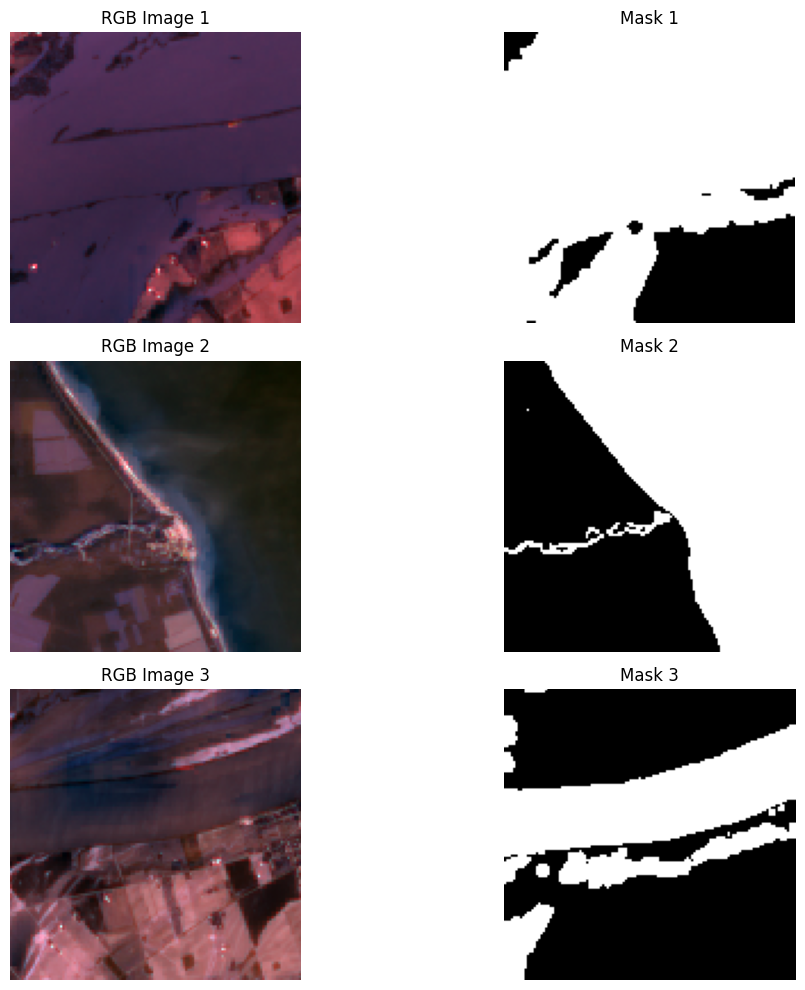

In [ ]:
def load_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # (bands, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, bands)
    return img

def load_mask(path):
    mask = plt.imread(path)
    mask = (mask > 0).astype(np.float32)
    return mask

def normalize_rgb(image):
    rgb = image[:, :, :3].astype(np.float32)

    for i in range(3):
        band = rgb[:, :, i]
        rgb[:, :, i] = (band - band.min()) / (band.max() - band.min() + 1e-8)

    return rgb

indices = random.sample(range(len(image_files)), 3)

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices):
    img_path = os.path.join(images_dir, image_files[idx])
    mask_path = os.path.join(labels_dir, label_files[idx])

    image = load_image(img_path)
    mask = load_mask(mask_path)
    rgb_display = normalize_rgb(image)

    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(rgb_display)
    plt.title(f"RGB Image {i+1}")
    plt.axis("off")


    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


**Split Train / Validation**

In [ ]:
images = []
masks = []

for img_file, mask_file in zip(image_files, label_files):
    img_path = os.path.join(images_dir, img_file)
    mask_path = os.path.join(labels_dir, mask_file)

    images.append(load_image(img_path))
    masks.append(load_mask(mask_path))

X = np.array(images)
y = np.array(masks)
y = np.expand_dims(y, axis=-1)
print("X shape:", X.shape)   # (N, 128,128,12)
print("y shape:", y.shape)   # (N,128,128,1)


X shape: (306, 128, 128, 12)
y shape: (306, 128, 128, 1)


In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (244, 128, 128, 12)
Validation: (62, 128, 128, 12)


**Normalization**

In [ ]:
X_train = X_train.astype(np.float32)

global_min = np.min(X_train, axis=(0,1,2))  # shape (12,)
global_max = np.max(X_train, axis=(0,1,2))

print(global_min)
print(global_max)

[-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.510e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
[ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]


In [ ]:
def normalize_global(X, gmin, gmax):
    return (X - gmin) / (gmax - gmin + 1e-8)

X_train = normalize_global(X_train, global_min, global_max)
X_val   = normalize_global(X_val, global_min, global_max)

**Model** **Building**

In [ ]:
def unet_effb3_12bands(input_shape=(128,128,12), n_classes=1, activation='sigmoid', freeze_top=3):
    inputs = layers.Input(shape=input_shape)

    # Reduce 12 bands → 3 channels
    x = layers.Conv2D(3, (1,1), padding='same', name='conv1x1_12to3')(inputs)


    # EfficientNetB0 encoder (no pretrained weights)
    base_model = EfficientNetB3(include_top=False, weights=None, input_tensor=x)

    # Freeze top layers
    for layer in base_model.layers[-freeze_top:]:
        layer.trainable = False

    # Skip connections
    skip_names = ["block2a_expand_activation",
                  "block3a_expand_activation",
                  "block4a_expand_activation"]
    skips = [base_model.get_layer(name).output for name in skip_names]

    x = base_model.output  # bottleneck

    # Decoder
    filters = [128, 64, 32]
    for i in reversed(range(len(skips))):
        # Resize
        x = layers.Resizing(skips[i].shape[1], skips[i].shape[2])(x)
        x = layers.Concatenate()([x, skips[i]])
        x = layers.Conv2D(filters[i], (3,3), padding='same', activation='relu')(x)
        x = layers.Conv2D(filters[i], (3,3), padding='same', activation='relu')(x)

    # Upsample
    x = layers.UpSampling2D(size=(2,2))(x)

    # Final output
    outputs = layers.Conv2D(n_classes, (1,1), activation=activation)(x)

    model = Model(inputs, outputs, name='UNet_EfficientNetB0_12bands_fixed')
    return model

In [ ]:
model = unet_effb3_12bands()
model.summary()

Model: "UNet_EfficientNetB0_12bands_fixed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1x1_12to3       │ (None, 128, 128,  │         39 │ input_layer_1[0]… │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ conv1x1_12to3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        960 │ block1a_se_excit

 Total params: 11,871,639 (45.29 MB)

 Trainable params: 11,191,440 (42.69 MB)

 Non-trainable params: 680,199 (2.59 MB)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
def f1_score(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return (2*tp + smooth) / (2*tp + fp + fn + smooth)


In [ ]:
# Compile with combined loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[iou_metric, f1_score]
)

In [ ]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("model.output_shape:", model.output_shape)

X_train.shape: (244, 128, 128, 12)
y_train.shape: (244, 128, 128, 1)
model.output_shape: (None, 128, 128, 1)


In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=20
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 216s 9s/step - f1_score: 0.4722 - iou_metric: 0.3292 - loss: 1.1278 - val_f1_score: 1.8233e-11 - val_iou_metric: 1.8233e-11 - val_loss: 1.3321
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - f1_score: 0.6508 - iou_metric: 0.4862 - loss: 0.7883 - val_f1_score: 3.4405e-04 - val_iou_metric: 1.7206e-04 - val_loss: 1.3435
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - f1_score: 0.7218 - iou_metric: 0.5691 - loss: 0.7176 - val_f1_score: 7.3916e-04 - val_iou_metric: 3.6973e-04 - val_loss: 1.3211
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 122s 8s/step - f1_score: 0.7334 - iou_metric: 0.5840 - loss: 0.6856 - val_f1_score: 0.0530 - val_iou_metric: 0.0272 - val_loss: 1.3139
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 132s 8s/step - f1_score: 0.7417 - iou_metric: 0.5956 - loss: 0.6569 - val_f1_score: 2.9443e-05 - val_iou_metric: 1.4722e-05 - val_loss: 1.3309
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - f1_score: 0.6902 - iou_metric: 0.5298 - loss: 0.69

In [28]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - f1_score: 9.6912e-12 - iou_metric: 9.6912e-12 - loss: 1.5640


[1.6036425828933716, 9.109528235906605e-12, 9.109528235906605e-12]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


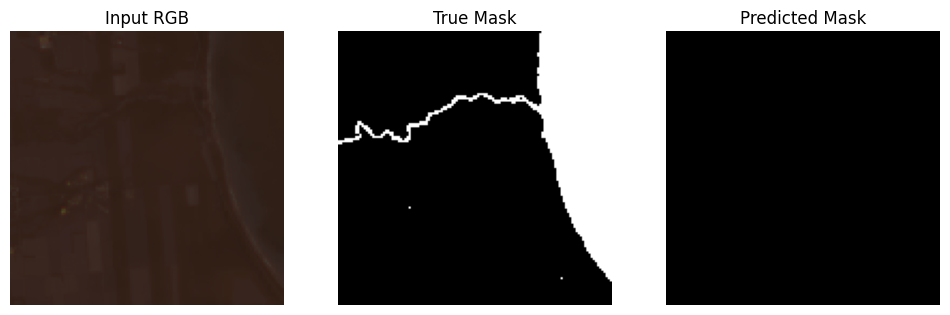

In [30]:
idx = np.random.randint(0, len(X_val))

img = X_val[idx]
true_mask = y_val[idx]

pred_mask = model.predict(img[np.newaxis,...])[0]
pred_mask_bin = (pred_mask>0.5).astype(np.float32)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img[:,:,:3])  # عرض RGB فقط
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(true_mask[:,:,0], cmap="gray")
plt.title("True Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask_bin[:,:,0], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()